In [1]:
from __future__ import annotations
from typing import List, Tuple, Sequence

from voronoi_site_suite import load_sites_cases, generate_sites
from viz_suite import render_sites,render_power_diagrams
from complexity_power import analyze_power_cells_complexity

In [2]:
from typing import Sequence, List, Tuple, Dict, Any

Point = Tuple[float, float]
WPoint = Tuple[int, int, int]           # (x, y, w)
HalfPlane = Tuple[float, float, float]  # ax + by <= c

def build_power_cells(sites_in: Sequence[WPoint], stats: bool = False) -> List[List[HalfPlane]] | Dict[str, Any]:
    """
    Input:
        sites_in — 已校验/去重/整型的加权点 [(x,y,w), ...]
        stats — 若为 True，则不返回几何结果，只返回复杂度统计信息。
    Output:
        stats=False: power_regions — list of per-site half-planes.
                     power_regions[i] = [(a,b,c), ...] with ax+by<=c
        stats=True:  {
            'n': n,
            'pairs': n*(n-1),
            'halfplanes_stored': n*(n-1),
            'ops': {
                'add': int,        # 加法次数
                'sub': int,        # 减法次数
                'mul': int,        # 乘法次数
                'assign': int,     # 变量赋值与列表追加的计数（粗略）
                'tuple_create': int# 三元组创建次数
            },
            'asymptotic': {
                'time': 'Theta(n^2)',
                'space': 'Theta(n^2)'
            }
        }
    说明：
        统计计数为与实现一致的“语句级”操作近似计数，便于对比不同 n 的增长趋势。
    """
    n = len(sites_in)
    if n < 2:
        raise ValueError("need at least 2 sites")

    if stats:
        add = sub = mul = assign = tuple_create = 0
        # 外层循环 i
        assign += 1  # power_regions 占位（与正常分支对齐思想）
        # 逐对 (i,j) 统计与实现保持一致
        for i in range(n):
            assign += 1  # 读取 xi,yi,wi
            xi, yi, wi = sites_in[i]
            for j in range(n):
                if j == i:
                    continue
                assign += 1  # 读取 xj,yj,wj
                xj, yj, wj = sites_in[j]

                # a = 2.0 * (xj - xi)
                sub += 1      # (xj - xi)
                mul += 1      # 2.0 * (...)
                assign += 1   # a =

                # b = 2.0 * (yj - yi)
                sub += 1
                mul += 1
                assign += 1

                # c = (xj*xj + yj*yj) - (xi*xi + yi*yi) + (wi - wj)
                mul += 2      # xj*xj, yj*yj
                add += 1      # (xj*xj + yj*yj)
                mul += 2      # xi*xi, yi*yi
                add += 1      # (xi*xi + yi*yi)
                sub += 1      # (...) - (...)
                sub += 1      # (wi - wj)
                add += 1      # + (wi - wj)
                assign += 1   # c =

                tuple_create += 1  # (a,b,c)
                assign += 1        # append 视为一次赋值计

        return {
            'n': n,
            'pairs': n * (n - 1),
            'halfplanes_stored': n * (n - 1),
            'ops': {
                'add': add,
                'sub': sub,
                'mul': mul,
                'assign': assign,
                'tuple_create': tuple_create
            },
            'asymptotic': {
                'time': 'Theta(n^2)',
                'space': 'Theta(n^2)'
            }
        }

    # 正常几何结果分支
    power_regions: List[List[HalfPlane]] = []
    for i in range(n):
        xi, yi, wi = sites_in[i]
        hi: List[HalfPlane] = []
        for j in range(n):
            if j == i:
                continue
            xj, yj, wj = sites_in[j]
            a = 2.0 * (xj - xi)
            b = 2.0 * (yj - yi)
            # 等价于能量距离等式展开：|p-xj|^2 - wj = |p-xi|^2 - wi
            c = (xj * xj + yj * yj) - (xi * xi + yi * yi) + (wi - wj)
            hi.append((a, b, c))
        power_regions.append(hi)
    return power_regions

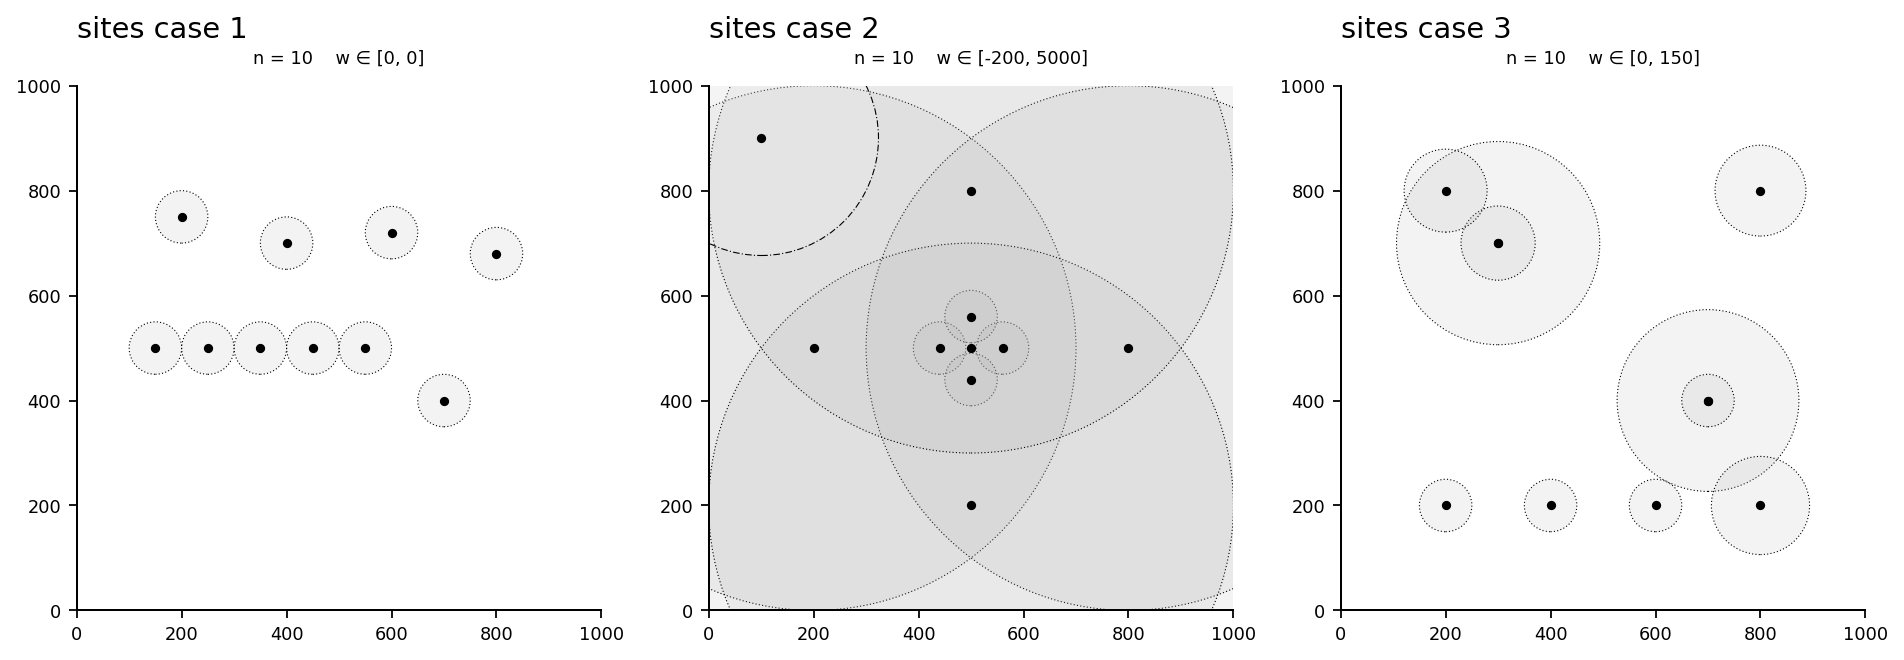

In [3]:
Sites = load_sites_cases()   
fig1 = render_sites(Sites, coord_range=1000, cols_per_row=3)

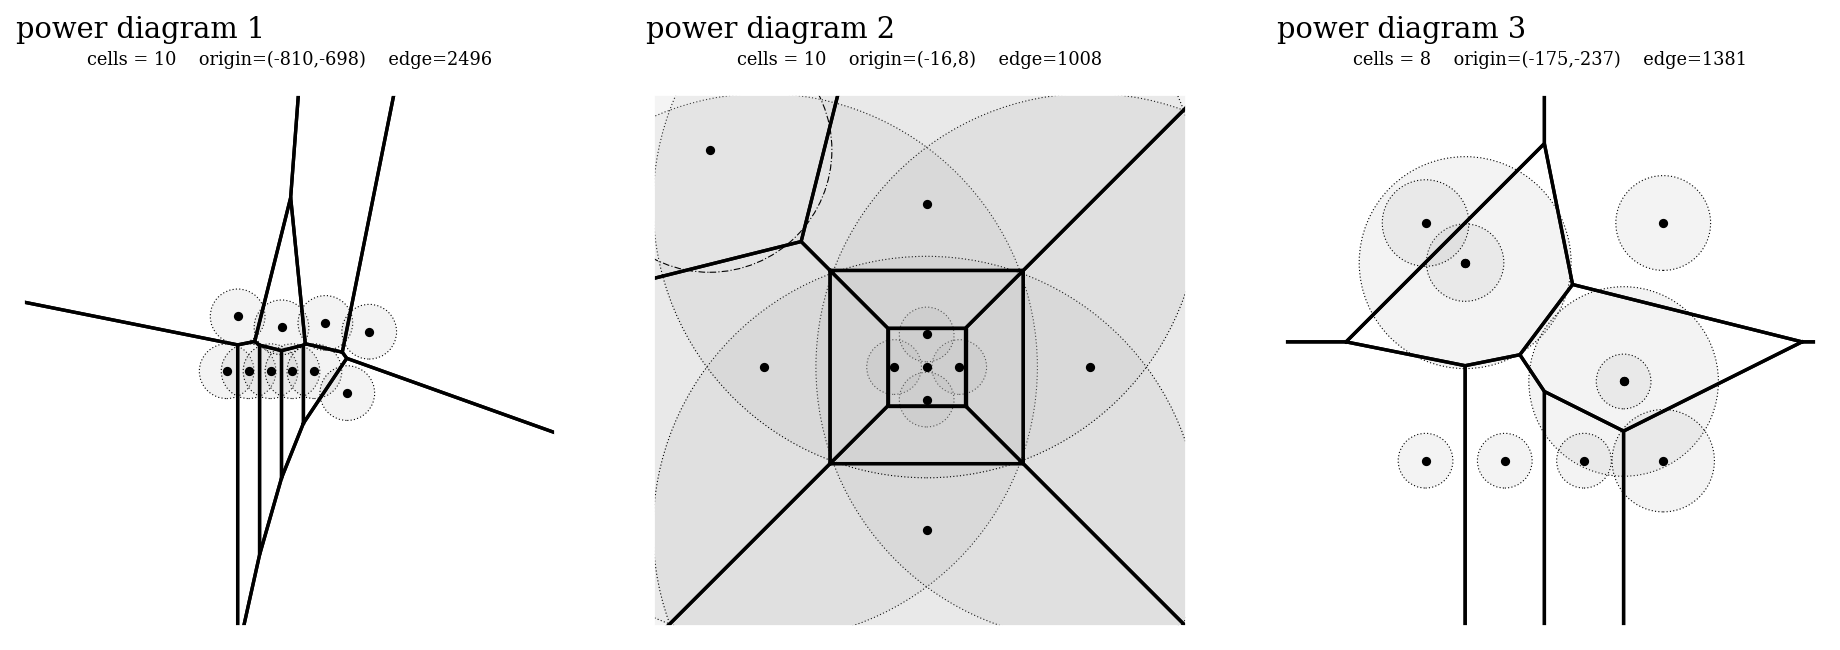

In [13]:
PRs = [build_power_cells(S) for S in Sites]
fig_pow = render_power_diagrams(Sites, PRs, cols_per_row=3, max_expand=53)

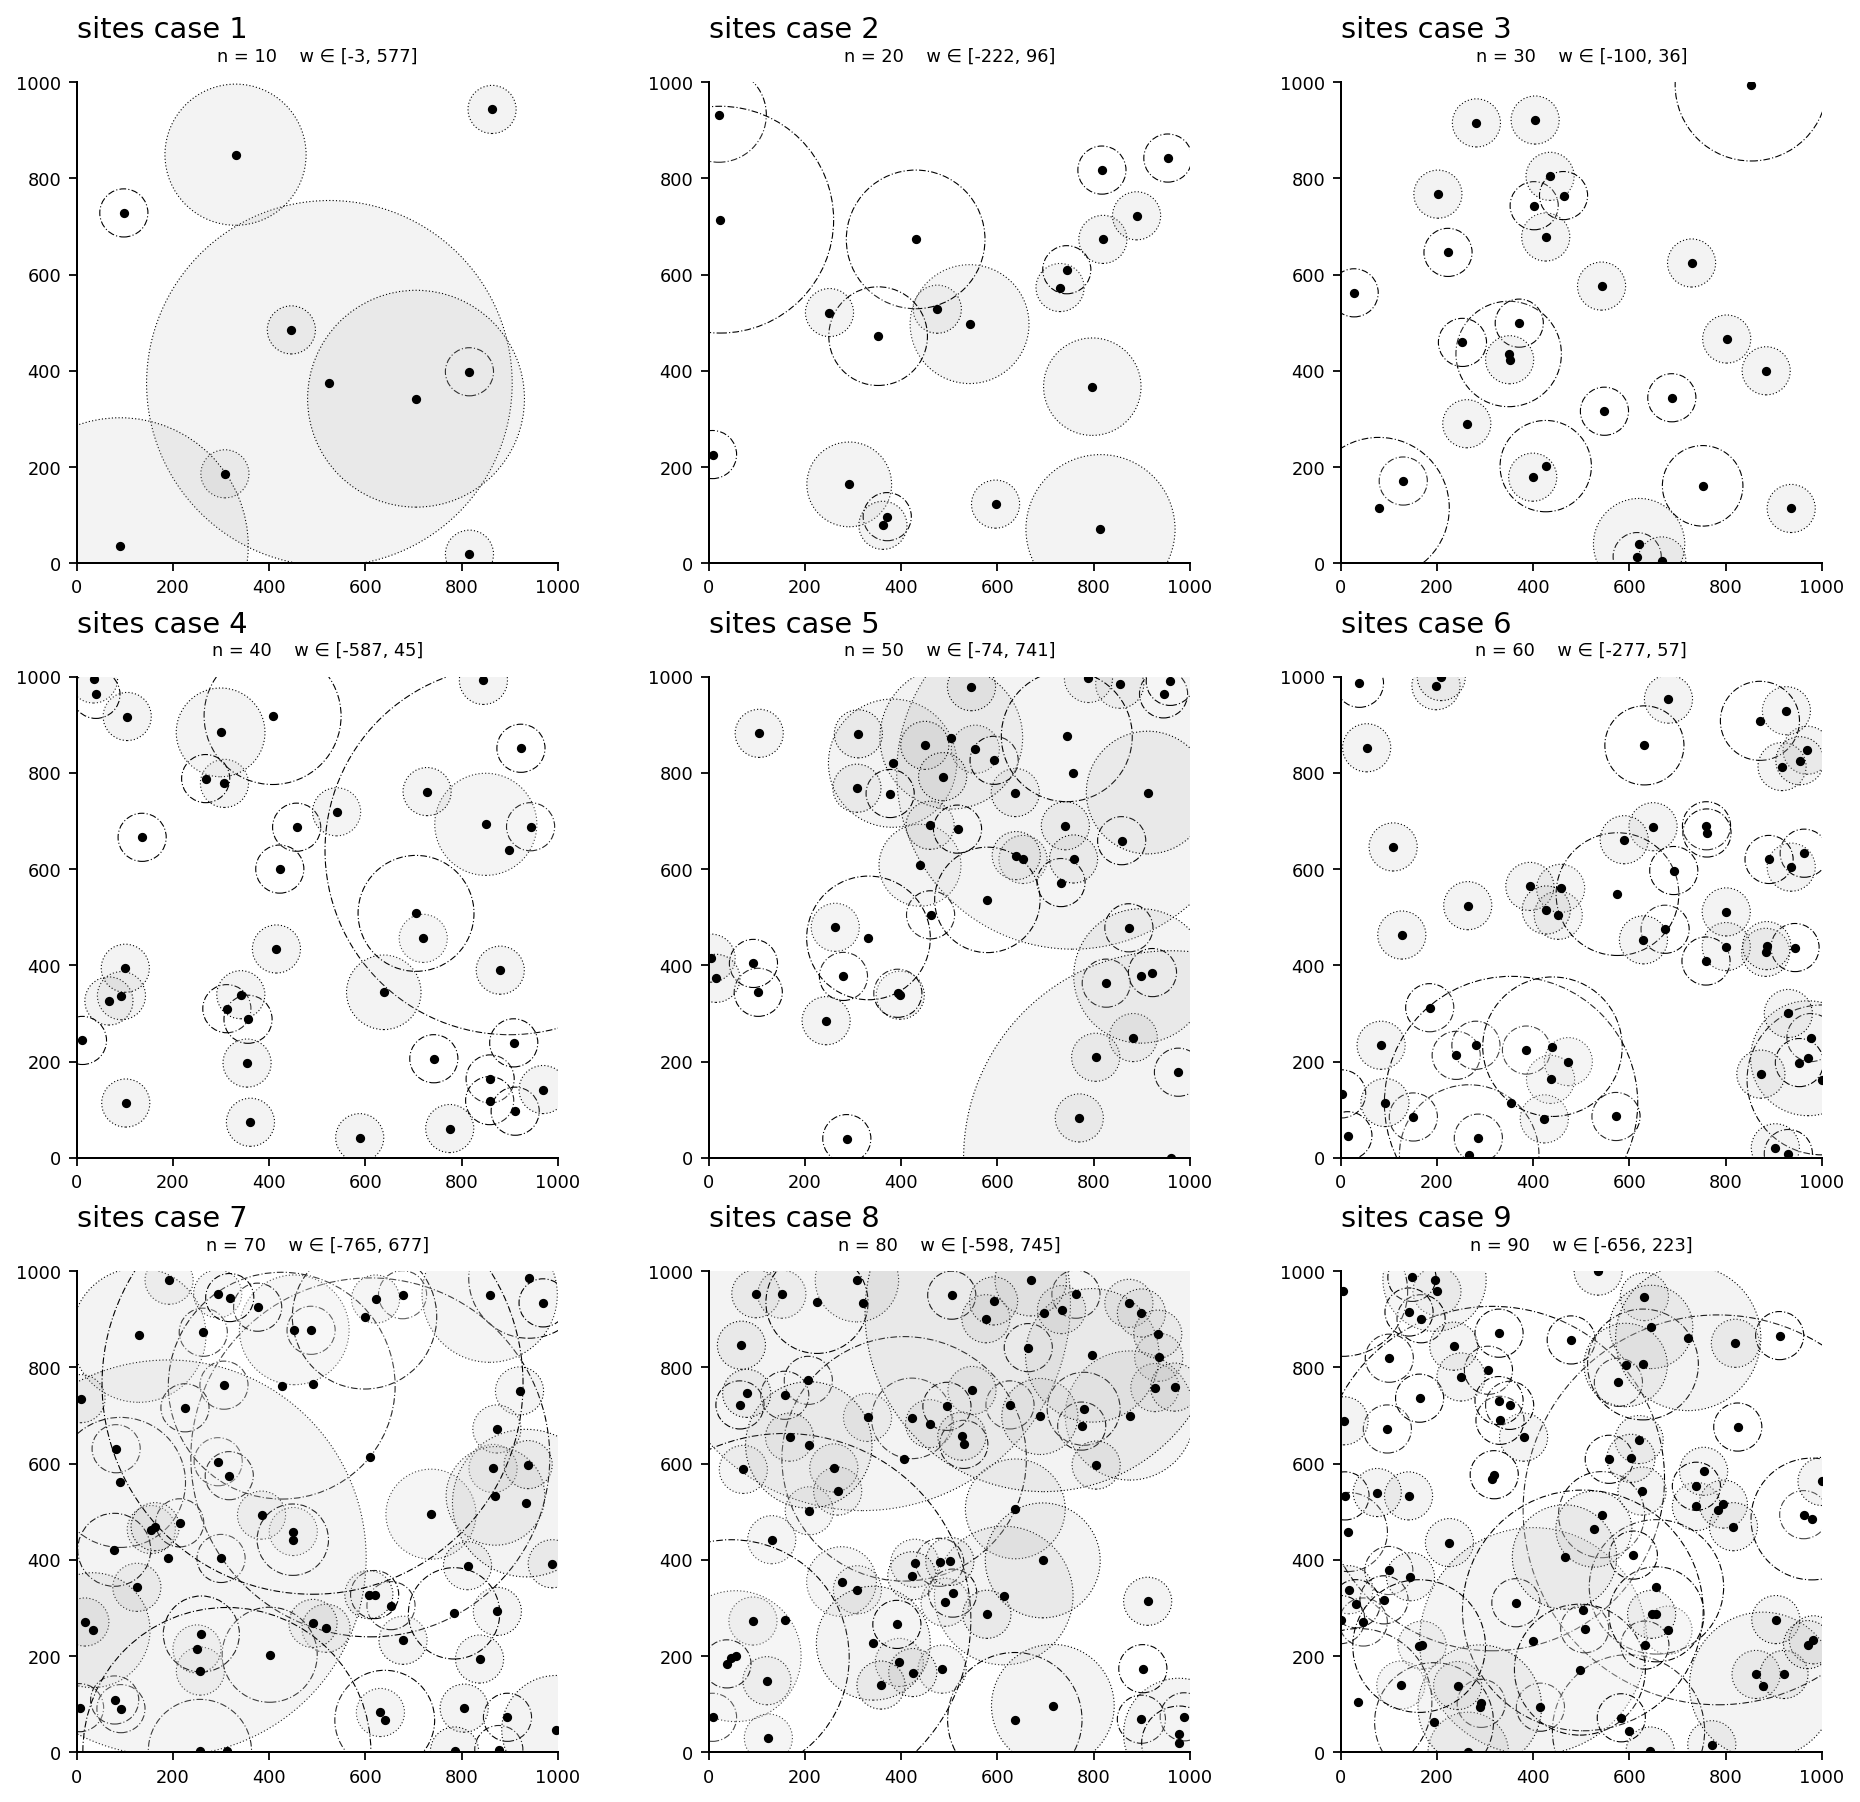

In [5]:
# TestSites = generate_sites([3,6,9,12,15,18,21,24,27], image_size=1000)
TestSites = generate_sites([10,20,30,40,50,60,70,80,90], image_size=1000,seed=1024)
fig3 = render_sites(TestSites, coord_range=1000, cols_per_row=3)

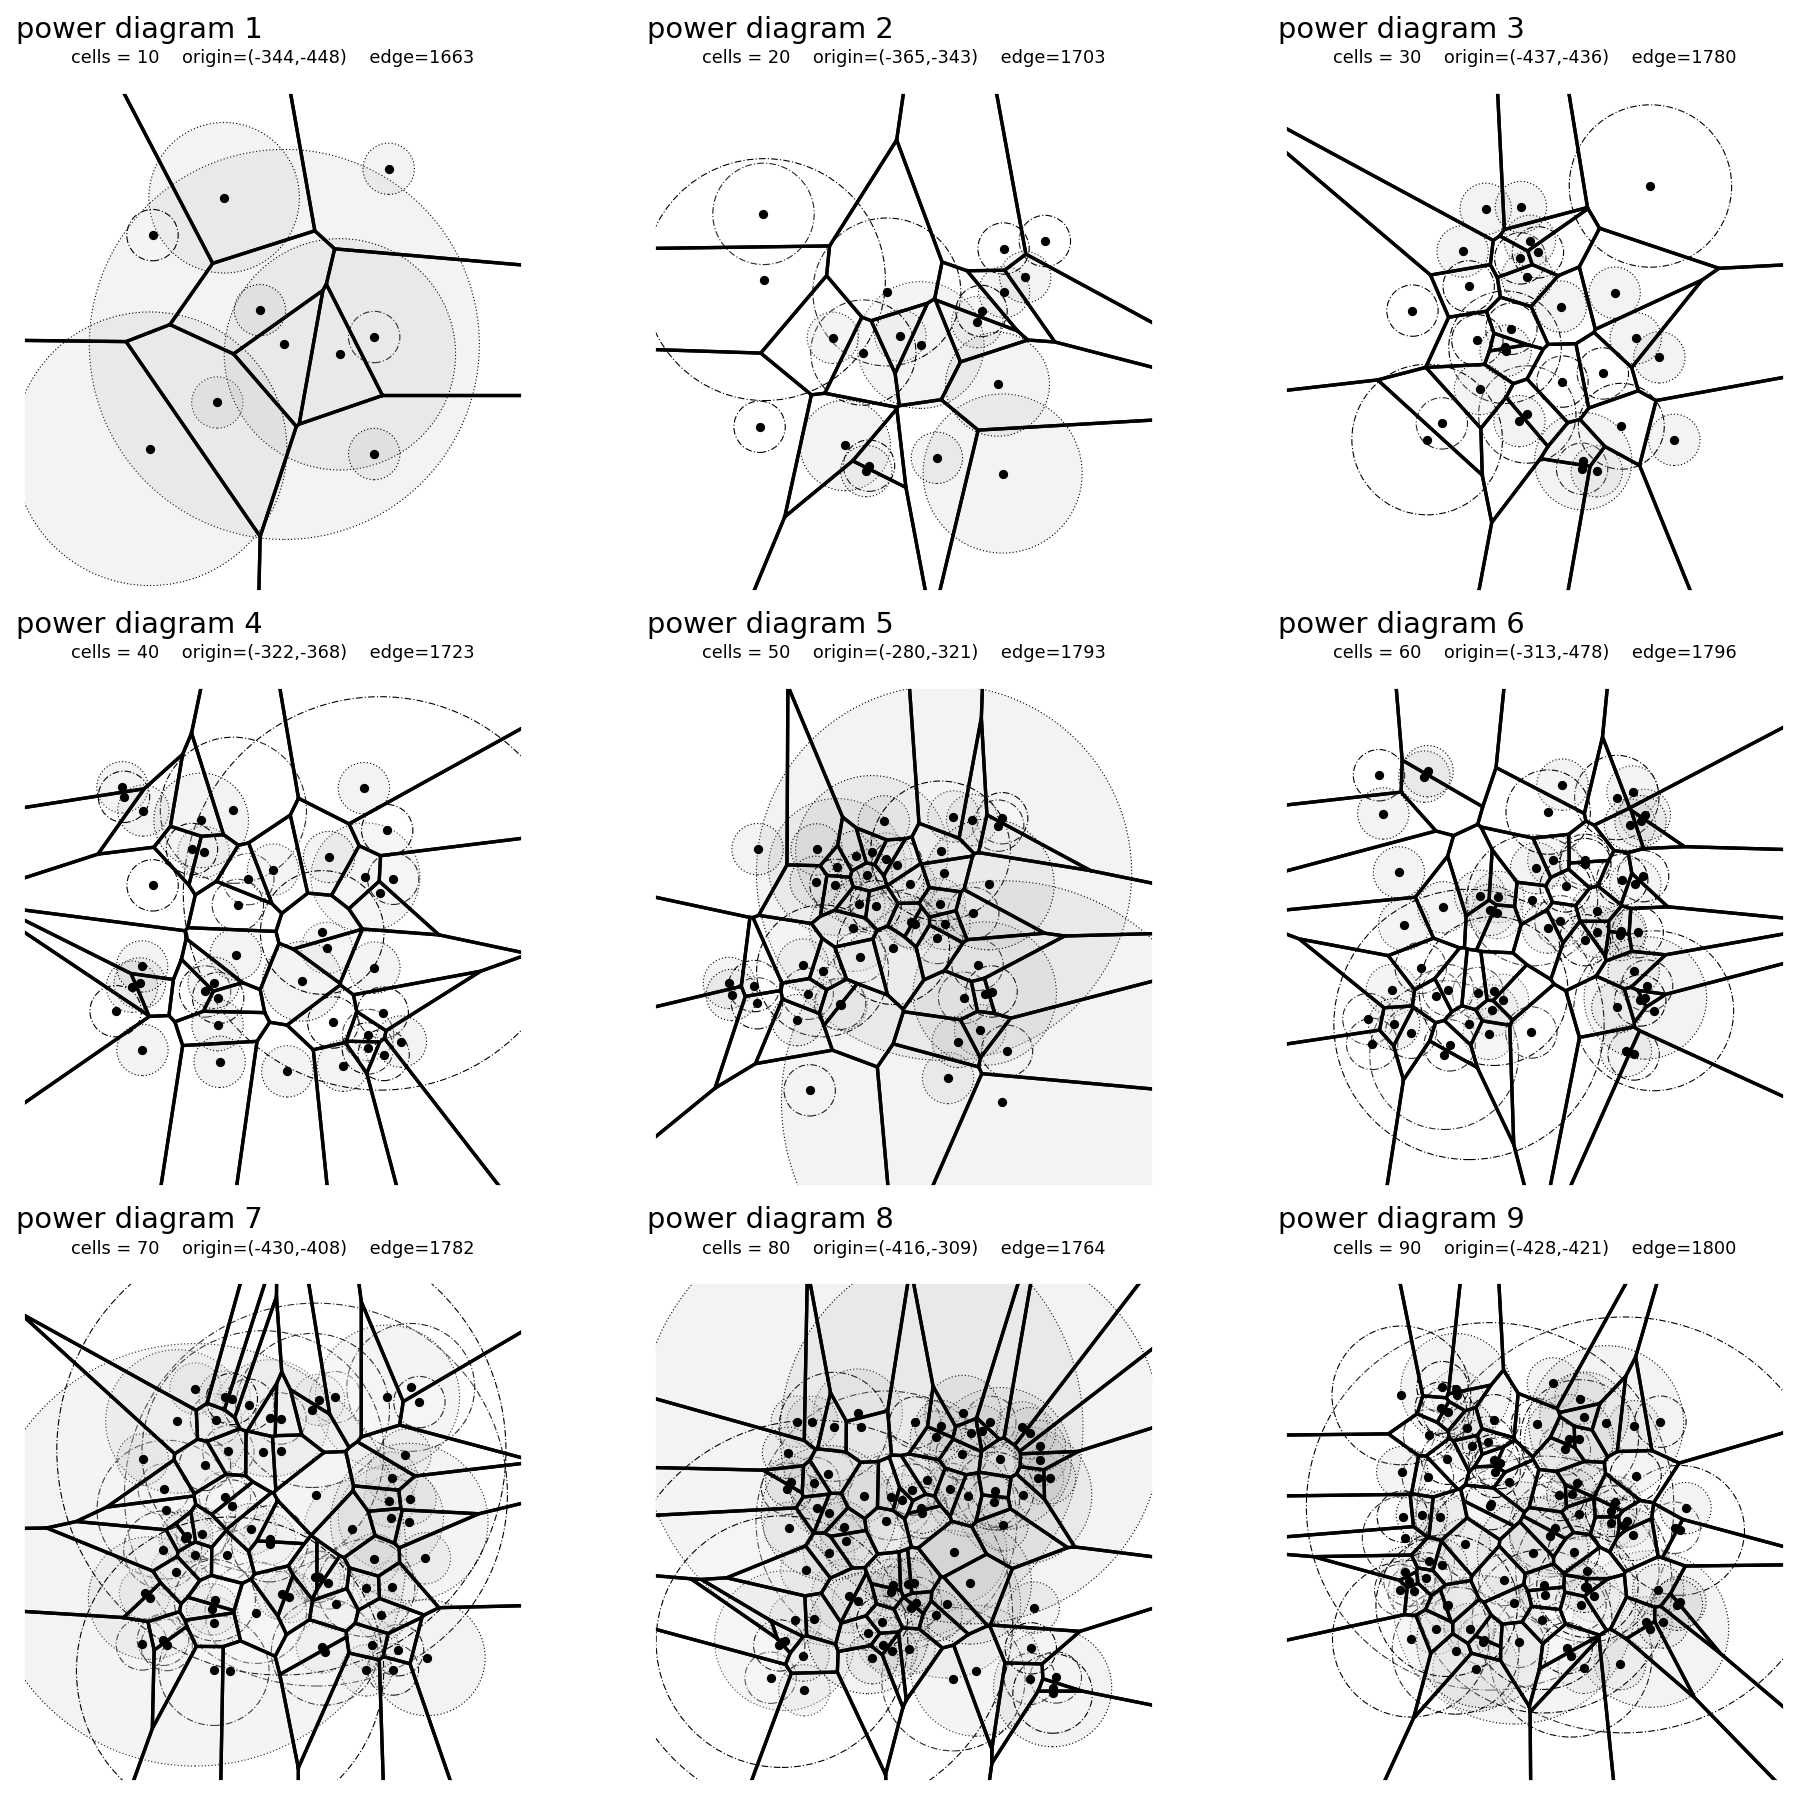

In [6]:
TestPRs = [build_power_cells(TS) for TS in TestSites]
fig4 = render_power_diagrams(TestSites, TestPRs, cols_per_row=3, max_expand=1.5)

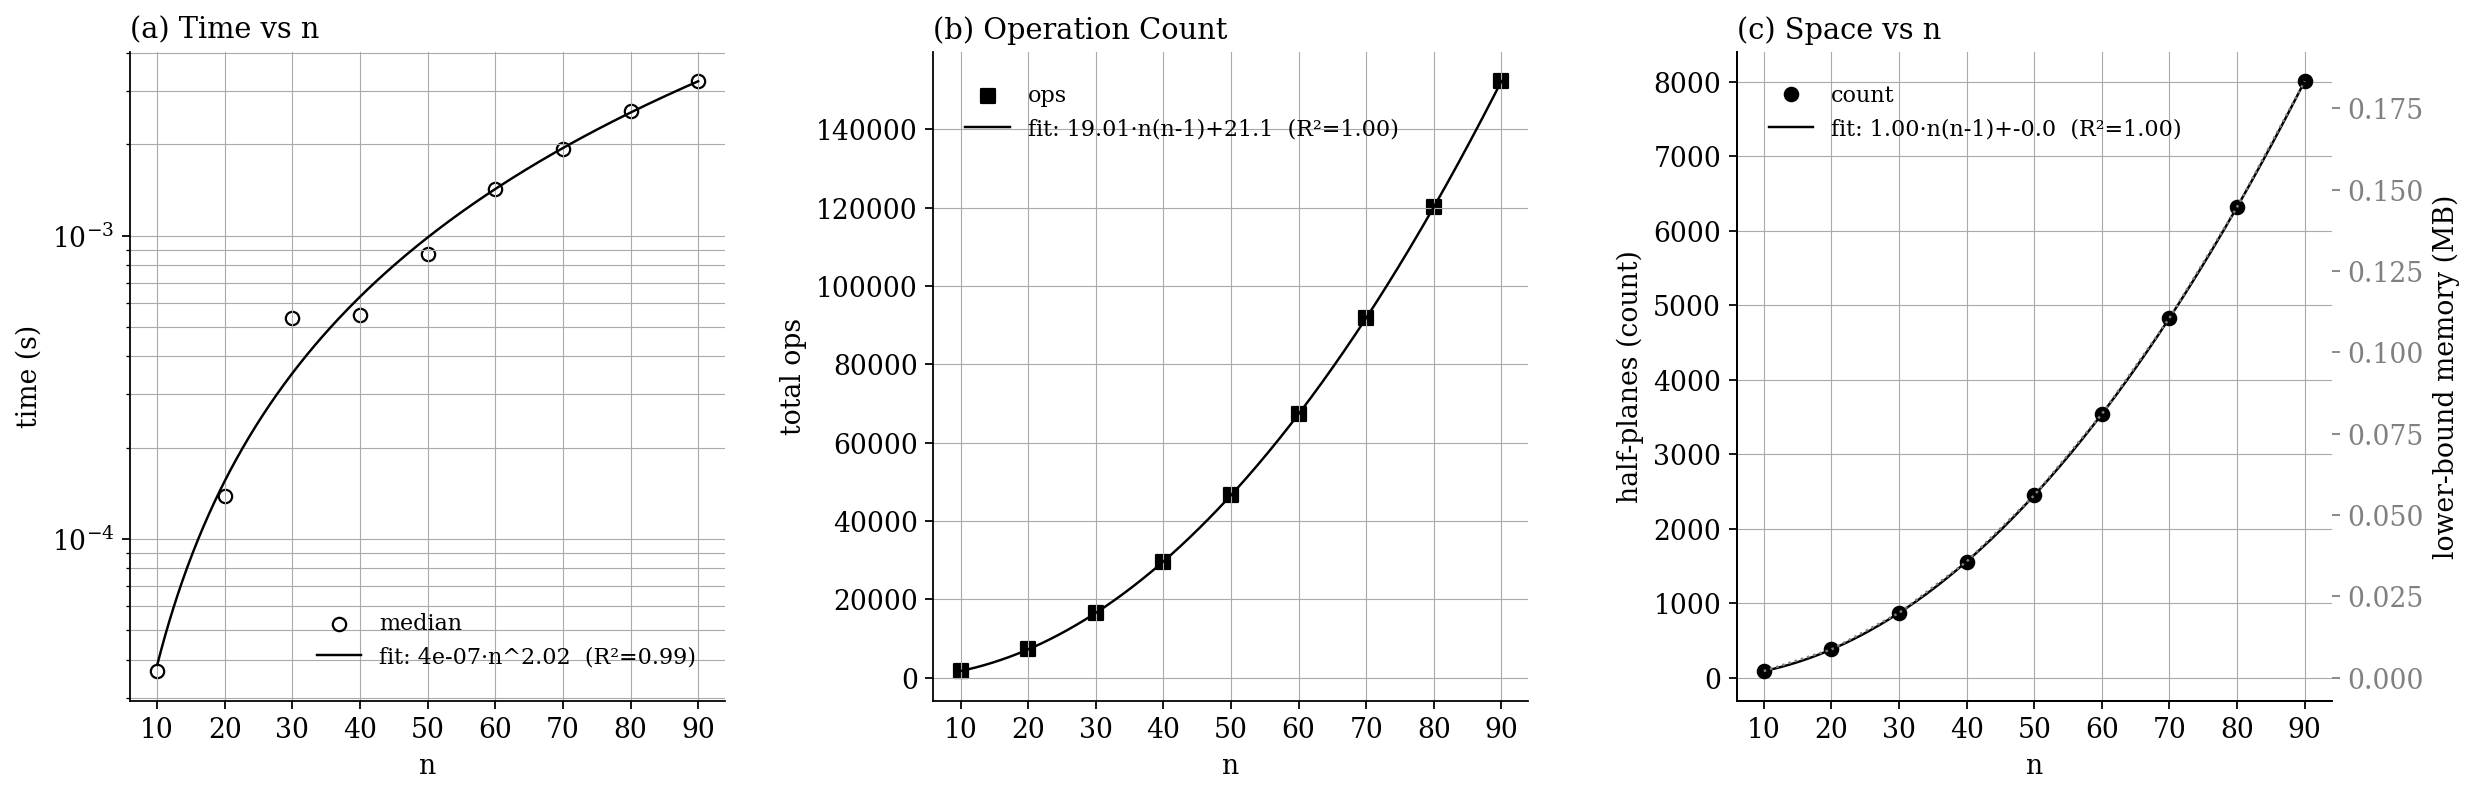

In [7]:
ep = analyze_power_cells_complexity(
    TestSites,
    build_power_cells,
    runs=5,
    show=True
)
